In [11]:
!pip install umap-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 2.5 MB/s eta 0:00:00


In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from sklearn.manifold import TSNE
import umap
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

from utils_cifar10 import *
from models import ResNet50, ResNet101

2024-05-18 08:47:12.512036: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-18 08:47:12.556554: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-18 08:47:12.556610: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-18 08:47:12.558025: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-18 08:47:12.566595: I tensorflow/core/platform/cpu_feature_guar

In [23]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [24]:
# Data augmentation and normalization for training
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Normalization for testing
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

In [25]:
batch_size=128

In [26]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [27]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [28]:
net = ResNet50().to(device)
if device == 'cuda':
    net = nn.DataParallel(net)
    torch.backends.cudnn.benchmark = True

In [29]:
epoch = 50

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=3e-5)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=5, min_lr=1e-5) 

In [30]:
Acc, Loss, Lr = train(net, trainloader, testloader, epoch, optimizer, criterion)

/opt/conda/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch [  1/ 50] | Train Loss:1.563373 | Train Acc:43.09% | Test Loss:1.258658 | Test Acc:54.28% | Learning Rate:0.001000 | Time: 00:45
Epoch [  2/ 50] | Train Loss:1.044539 | Train Acc:62.52% | Test Loss:1.004048 | Test Acc:65.79% | Learning Rate:0.001000 | Time: 00:46
Epoch [  3/ 50] | Train Loss:0.844254 | Train Acc:70.18% | Test Loss:0.840123 | Test Acc:71.42% | Learning Rate:0.001000 | Time: 00:46
Epoch [  4/ 50] | Train Loss:0.703550 | Train Acc:75.35% | Test Loss:0.838802 | Test Acc:73.38% | Learning Rate:0.001000 | Time: 00:46
Epoch [  5/ 50] | Train Loss:0.612973 | Train Acc:78.86% | Test Loss:0.719036 | Test Acc:75.91% | Learning Rate:0.001000 | Time: 00:45
Epoch [  6/ 50] | Train Loss:0.548374 | Train Acc:81.07% | Test Loss:0.708160 | Test Acc:76.77% | Learning Rate:0.001000 | Time: 00:45
Epoch [  7/ 50] | Train Loss:0.500670 | Train Acc:82.98% | Test Loss:0.532076 | Test Acc:82.08% | Learning Rate:0.001000 | Time: 00:47
Epoch [  8/ 50] | Train Loss:0.467385 | Train Acc:83.98

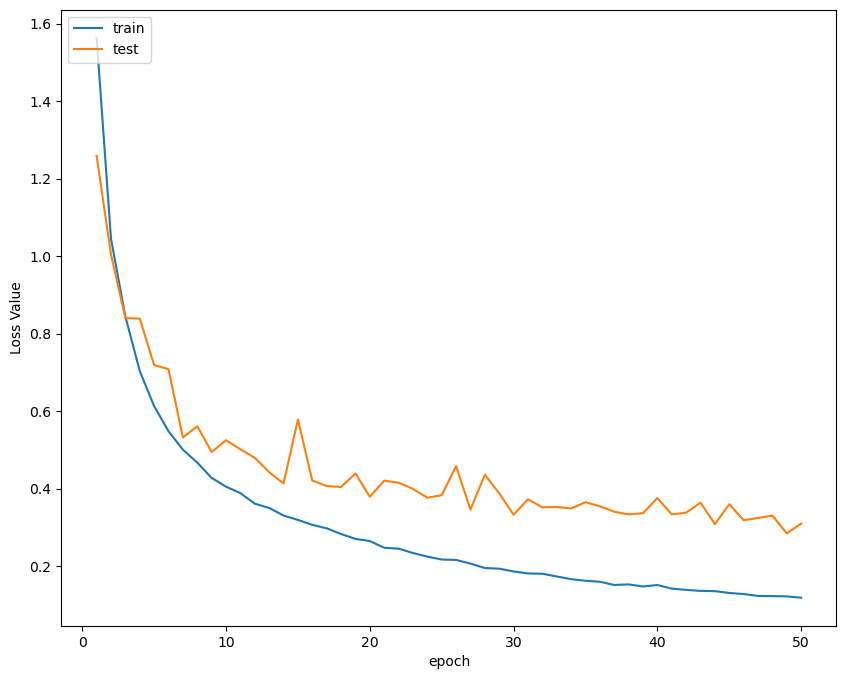

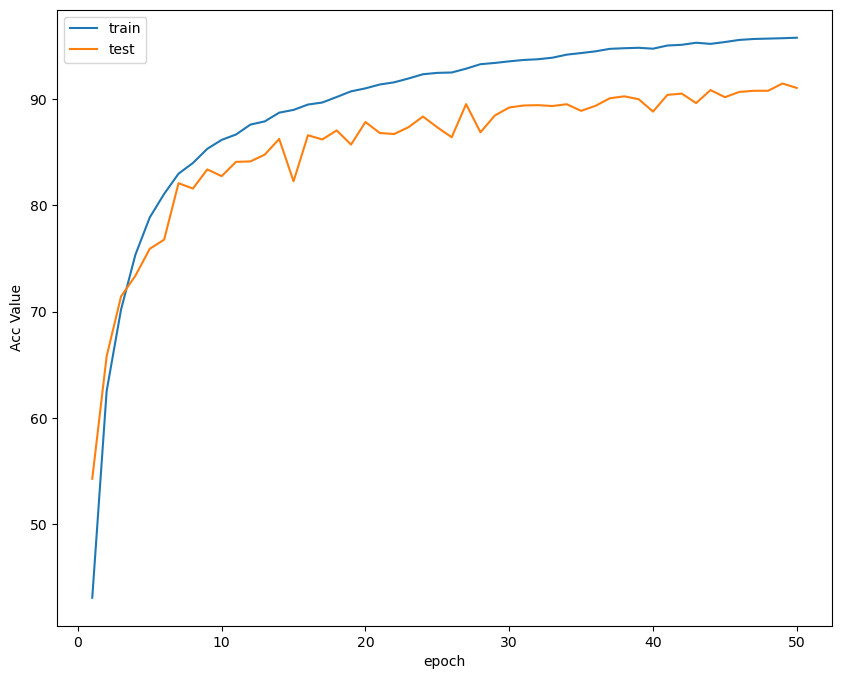

In [31]:
plot_history(epoch, Acc, Loss)

In [32]:
correct = 0 # Define the number of correctly predicted images, initialized to 0
total = 0 # The total number of pictures participating in the test, also initialized to 0
torch.cuda.empty_cache()
net.eval()
with torch.no_grad():
    for data in testloader: # Loop through each batch
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        net.eval() # Convert the model to test mode
        if hasattr(torch.cuda, 'empty_cache'):
            torch.cuda.empty_cache()
        outputs = net(images) # Enter the network for testing

        # outputs.data is a 4x10 tensor. The value and sequence number of the largest column of each row are formed into a one-dimensional tensor to return, the first is the value tensor, and the second is the sequence number tensor.
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0) # update the number of test images
        correct += (predicted == labels).sum() # update the number of correctly classified images

    print('Accuracy of the network on the 10000 test images: %.2f %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 91.01 %


In [33]:
# Define 2 lists that store the number of correct tests in each class, initialized to 0
class_correct = list(0.for i in range(10))
class_total = list(0.for i in range(10))
net.eval()
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        if hasattr(torch.cuda, 'empty_cache'):
            torch.cuda.empty_cache()
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
    #4 group (batch_size) data, output in the same label, marked as 1, otherwise 0
        c = (predicted == labels).squeeze()
        for i in range(len(images)): # Because each batch has 4 images, a small loop of 4 is needed
            label = labels[i] # Accumulate each class separately
            class_correct[label] += c[i]
            class_total[label] += 1
 
 
for i in range(10):
    print('Accuracy of %5s : %.2f %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 93.50 %
Accuracy of   car : 98.10 %
Accuracy of  bird : 86.80 %
Accuracy of   cat : 77.20 %
Accuracy of  deer : 91.90 %
Accuracy of   dog : 90.40 %
Accuracy of  frog : 96.20 %
Accuracy of horse : 90.60 %
Accuracy of  ship : 93.90 %
Accuracy of truck : 91.50 %


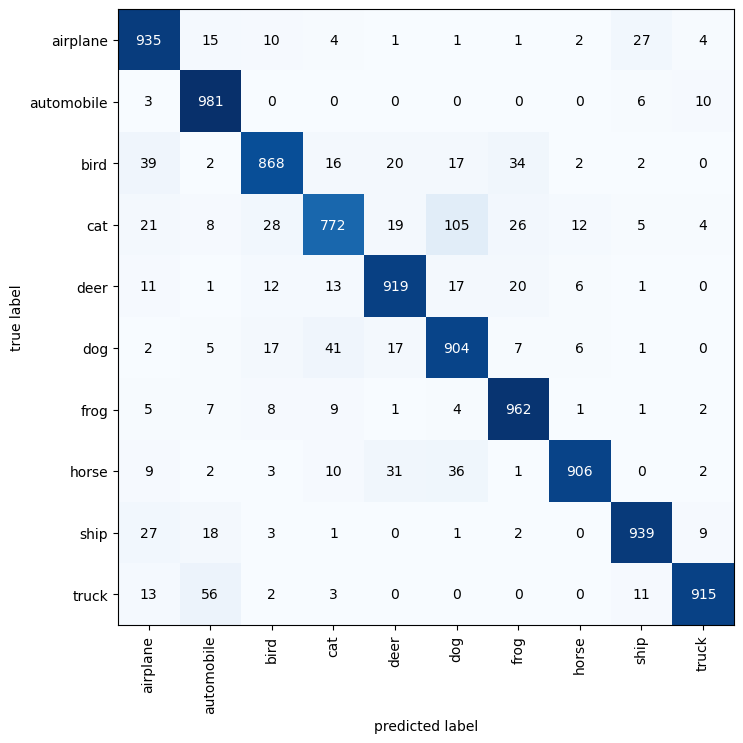

In [34]:
import numpy as np
from itertools import product

class_dict = {0: 'airplane',
              1: 'automobile',
              2: 'bird',
              3: 'cat',
              4: 'deer',
              5: 'dog',
              6: 'frog',
              7: 'horse',
              8: 'ship',
              9: 'truck'}

mat = compute_confusion_matrix(model=net, data_loader=testloader, device=torch.device('cpu'))
plot_confusion_matrix(mat, class_names=class_dict.values())
plt.show()

# Visualizing for discriminability of ResNet50 

In [123]:
feature_maps = []

def hook_fn(module, input, output):
    feature_maps.append(output)

# Register the hook
hook = model.layer4[-1].register_forward_hook(hook_fn)

In [127]:
net.eval()
features = []
labels = []

with torch.no_grad():
    for data, target in trainloader:
        data, target = data.to(device), target.to(device)  # Move data and labels to GPU
        output = net(data)
        features.append(output.view(output.size(0), -1).detach().cpu().numpy())
        labels.append(target.cpu().numpy())

features = np.concatenate(features)
labels = np.concatenate(labels)

In [143]:
hook.remove()

In [131]:
tsne = TSNE(n_components=2, random_state=33)
tsne_features = tsne.fit_transform(features)

umap_reducer = umap.UMAP(n_components=2, random_state=33)
umap_features = umap_reducer.fit_transform(features)

pca = PCA(n_components=2)
pca_features = pca.fit_transform(features)

/opt/conda/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


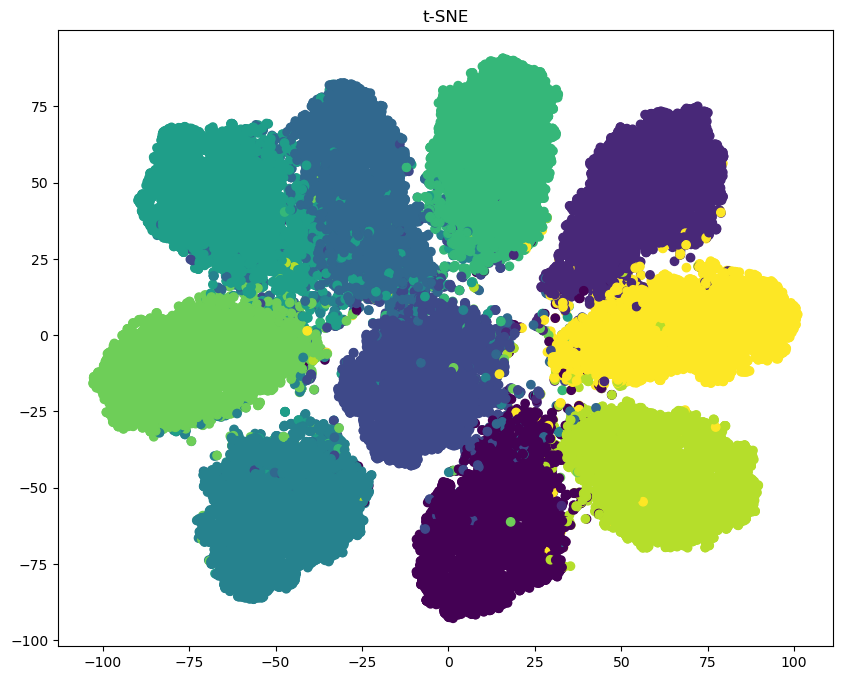

In [133]:
plt.scatter(tsne_features[:, 0], tsne_features[:, 1], c=labels, cmap='viridis')
plt.title('t-SNE')
plt.show()

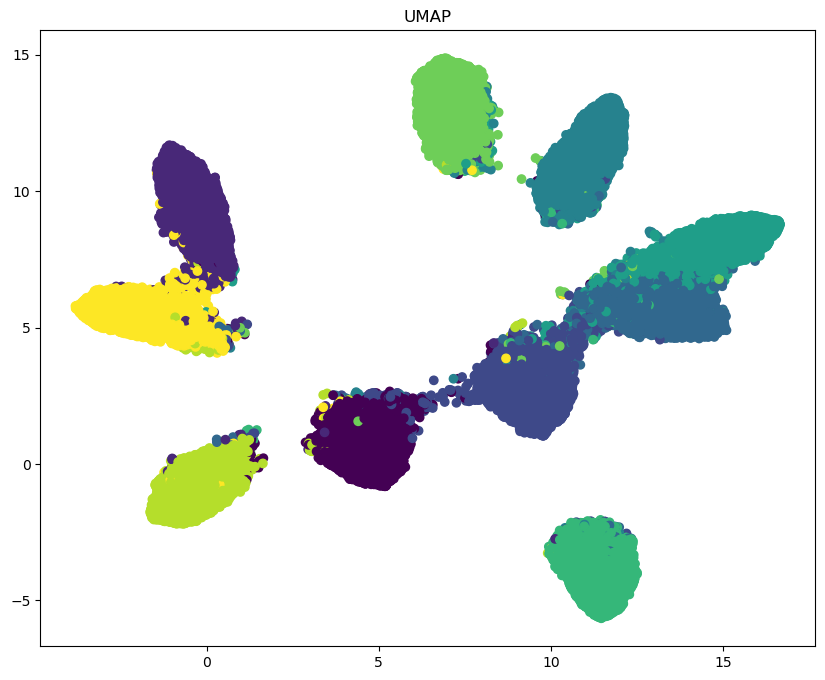

In [134]:
plt.scatter(umap_features[:, 0], umap_features[:, 1], c=labels, cmap='viridis')
plt.title('UMAP')
plt.show()

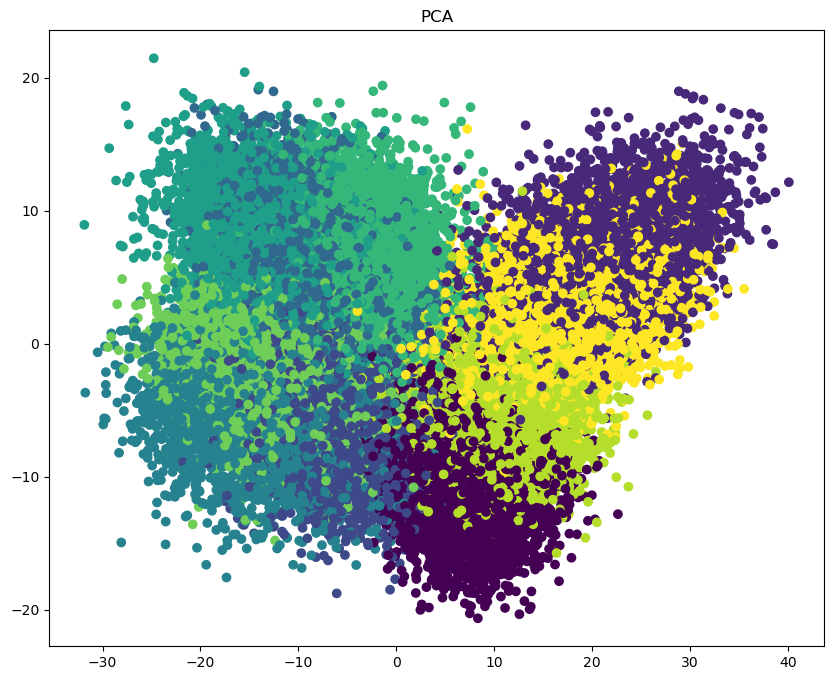

In [135]:
plt.scatter(pca_features[:, 0], pca_features[:, 1], c=labels, cmap='viridis')
plt.title('PCA')
plt.show()

In [136]:
feature_maps = []

def hook_fn(module, input, output):
    feature_maps.append(output)

# Register the hook
hook = model.avgpool.register_forward_hook(hook_fn)

In [137]:
net.eval()
features = []
labels = []

with torch.no_grad():
    for data, target in trainloader:
        data, target = data.to(device), target.to(device)  # Move data and labels to GPU
        output = net(data)
        features.append(output.view(output.size(0), -1).detach().cpu().numpy())
        labels.append(target.cpu().numpy())

features = np.concatenate(features)
labels = np.concatenate(labels)

In [138]:
hook.remove()

In [139]:
tsne = TSNE(n_components=2, random_state=33)
tsne_features = tsne.fit_transform(features)

umap_reducer = umap.UMAP(n_components=2, random_state=33)
umap_features = umap_reducer.fit_transform(features)

pca = PCA(n_components=2)
pca_features = pca.fit_transform(features)

/opt/conda/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


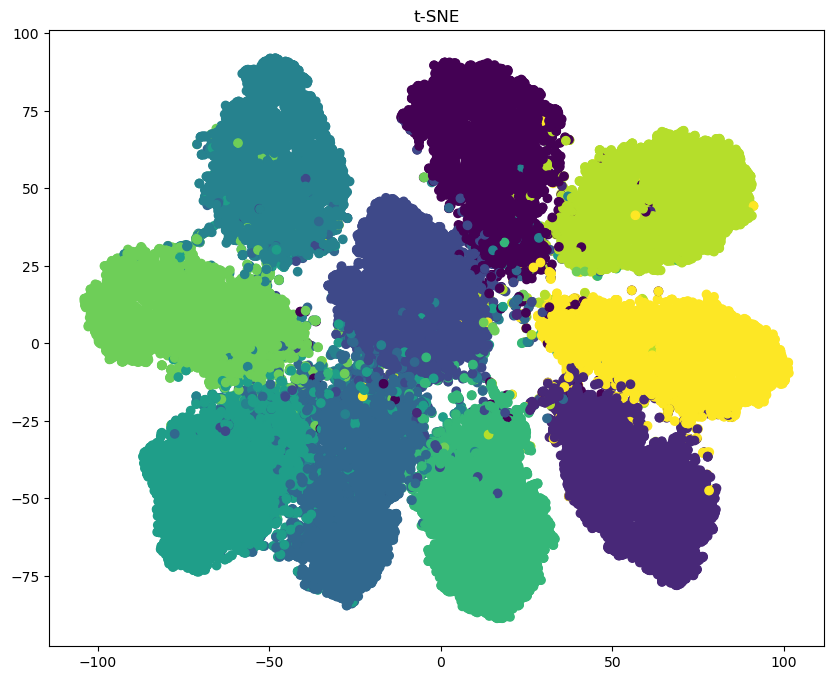

In [140]:
plt.scatter(tsne_features[:, 0], tsne_features[:, 1], c=labels, cmap='viridis')
plt.title('t-SNE')
plt.show()

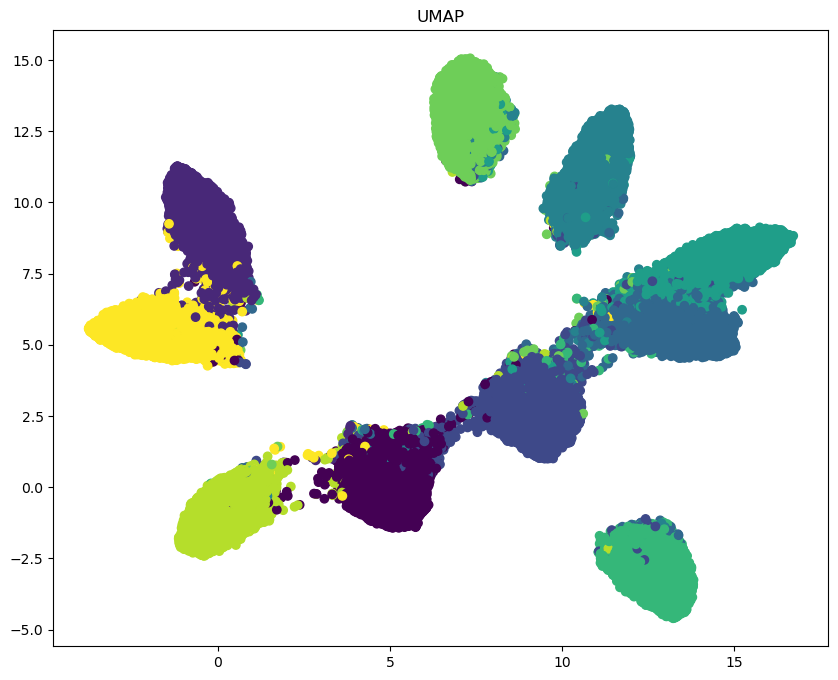

In [141]:
plt.scatter(umap_features[:, 0], umap_features[:, 1], c=labels, cmap='viridis')
plt.title('UMAP')
plt.show()

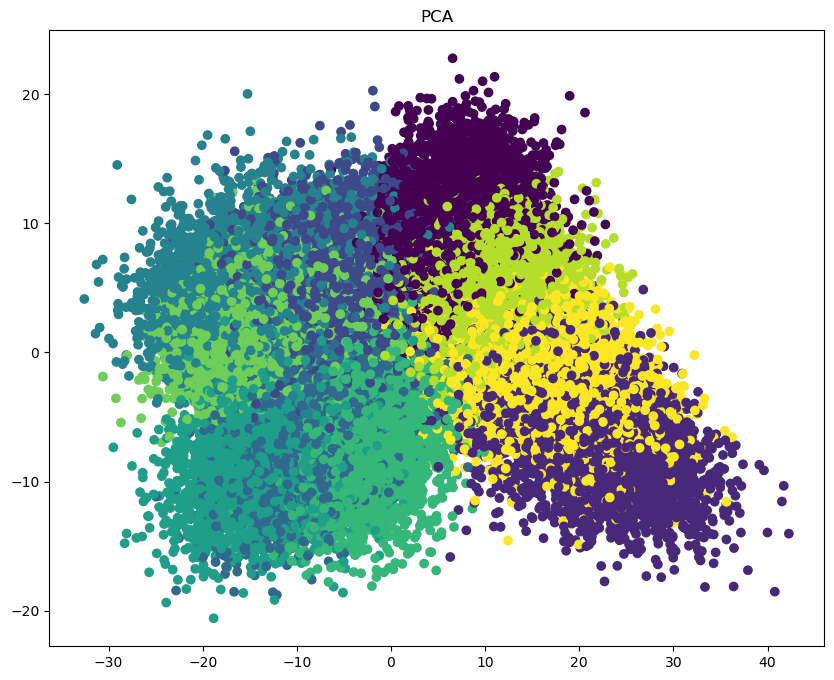

In [142]:
plt.scatter(pca_features[:, 0], pca_features[:, 1], c=labels, cmap='viridis')
plt.title('PCA')
plt.show()